# Projet 07 : Effectuer une prédiction de revenus

---
**Importation des librairies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as plc
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
import modules_perso.sf_graphiques as sfg

---
## <font color=blue>Mission 4 : Modélisation du revenu des individus</font>

### 4.5.c. ANOVA du logarithme du revenu basée sur le logarithme du revenu moyen et l'indice de Gini du pays, et leur interaction

In [4]:
data = pd.read_csv("data_analyse04.csv", index_col=0)
data["interaction"] = data.ln_revenu_moyen * data.gini_from_centiles
data.head()

C:\Anaconda3\envs\Jupyter\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ln_child_income,ln_revenu_moyen,gini_from_centiles,interaction
0,6.591534,8.004643,32.141019,257.277373
1,6.591534,8.004643,32.141019,257.277373
2,6.591534,8.004643,32.141019,257.277373
3,6.591534,8.004643,32.141019,257.277373
4,6.591534,8.004643,32.141019,257.277373


In [5]:
anova = smf.ols(formula="ln_child_income ~ ln_revenu_moyen + gini_from_centiles + ln_revenu_moyen:gini_from_centiles", data=data).fit()

In [6]:
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_child_income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 5.049e+06
Date:                Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:03:44   Log-Likelihood:            -6.1619e+06
No. Observations:             5642420   AIC:                         1.232e+07
Df Residuals:                 5642416   BIC:                         1.232e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              0.4605      0.013     35.079      0.000       0.435       0.486
ln_revenu_moyen                        0.9906      0.002    638.093      0.000       0.988       0.994
gini_from_centiles                    -0.0156      0.000    -46.149      0.000      -0.016      -0.015
ln_revenu_moyen:gini_from_centiles    -0.0001   4.06e-05     -2.747      0.006      -0.000    -3.2e-05
==============================================================================
Omnibus:                   366450.351   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1732554.991
Skew:                          -0.087   Prob(JB):                         0.00
Kurtosis:                       5.709   Cond. No.                     1.44e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
ln_revenu_moyen,6.662550e+06,1.0,1.281039e+07,0.000000,6.861091e-01,6.861088e-01
gini_from_centiles,1.135132e+05,1.0,2.182570e+05,0.000000,1.168958e-02,1.168940e-02
ln_revenu_moyen:gini_from_centiles,3.925974e+00,1.0,7.548653e+00,0.006006,4.042967e-07,2.270677e-07
Residual,2.934561e+06,5642416.0,NaN,NaN,NaN,NaN
total,9.710628e+06,5642419.0,NaN,NaN,NaN,NaN


La part de dispersion expliquée par le modèle (R²) est de 72,9%, comme pour le modèle 4 de base. Les scores AIC et BIC restent également identiques. Cela laisse présager que l'ajout de l'interaction n'est pas intéressant, car à qualité d'analyse et de prédiction équivalente, il faut priviligier le modèle avec le moins de variables.  
L'ANOVA conclut à la significativité des deux variables et de leur interaction, même si la contribution de l'interaction au modèle est extrêmement faible. Ce qui est intéressant d'analyser est l'impact de l'interaction sur la distribution des résidus et sur leur indépendance vis-à-vis des exogènes.

### Vérification des hypothèses

**Hypothèse 1 : Normalité des résidus**

In [8]:
alpha_normalite = 0.05
ad_stat, ad_pvalue = sm.stats.normal_ad(anova.resid)
norm_stat, norm_pvalue = st.kstest(anova.resid, cdf='norm', args=(anova.resid.mean(), anova.resid.var(ddof=1)))
jb_stat, jb_pvalue, skw, kurt = sm.stats.stattools.jarque_bera(anova.resid)
df_normalite = pd.DataFrame({'H0':np.repeat("Distribution normale",3), 'Statistique':["{:.2f}".format(ad_stat),"{:.2f}".format(norm_stat),"{:.2f}".format(jb_stat)], \
                             'p-value':["{:.3f}".format(ad_pvalue),"{:.3f}".format(norm_pvalue),"{:.3f}".format(jb_pvalue)]}, index=["Anderson-Darling","Kolmogorov-Smirnov","Jarque-Bera"])
inter_col = "Résultat (seuil={:.1%})".format(alpha_normalite)
df_normalite[inter_col] = ["Normalité acceptée" if float(pval)>=alpha_normalite else "Normalité rejetée" for pval in df_normalite["p-value"]]
df_normalite

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


,H0,Statistique,p-value,Résultat (seuil=5.0%)
Anderson-Darling,Distribution normale,19924.39,0.000,Normalité rejetée
Kolmogorov-Smirnov,Distribution normale,0.05,0.000,Normalité rejetée
Jarque-Bera,Distribution normale,1732554.99,0.000,Normalité rejetée


Aucun des trois test n'accepte la normalité. Nous avons un grand nombre d'observations. Une symétrie de la distribution des résidus sera suffisante. Je vérifie graphiquement cette symétrie, et je trace également la droite de Henry.

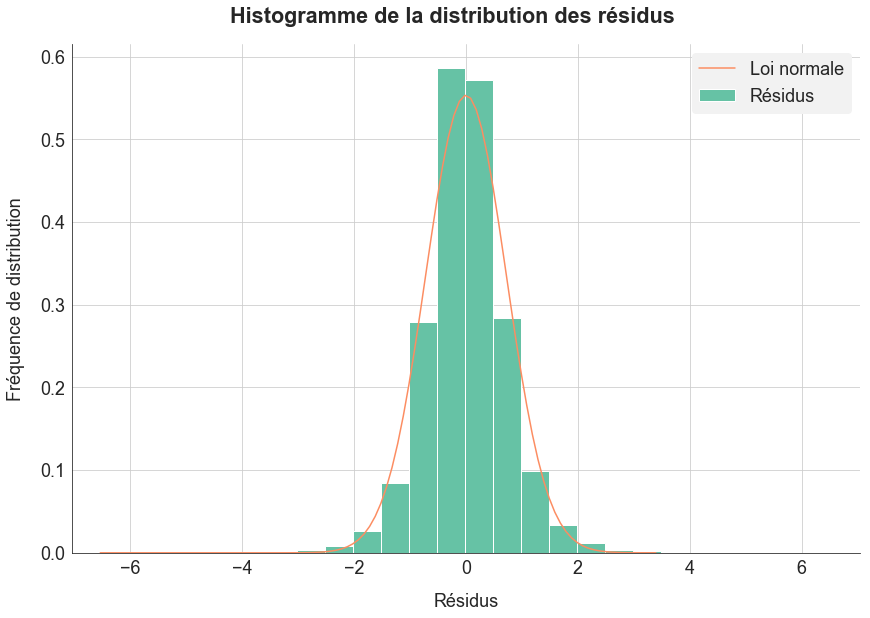

In [9]:
x_theo = np.arange(anova.resid.min(), anova.resid.max(), 0.01*(anova.resid.max()-anova.resid.min()))
mygraph = sfg.MyGraph("Histogramme de la distribution des résidus", is_mono=False)
mygraph.add_histogramme(anova.resid, bins=20, labels="Résidus")
mygraph.add_plot(x_theo, st.norm.pdf(x_theo, scale=anova.resid.std(ddof=1)), label="Loi normale", legend=True)
xmin, xmax = mygraph.ax[0].get_xlim()
absmax = max(-xmin, xmax)
mygraph.set_axe('y', label="Fréquence de distribution")
mygraph.set_axe('x', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04c_01_distribution_residus.png")
plt.show()

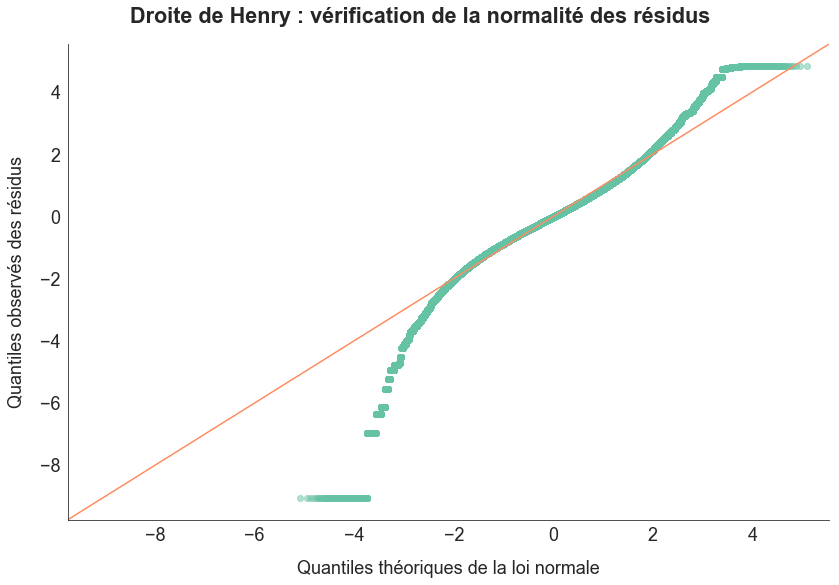

In [10]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04c_02_droite_henry.png")
plt.show()

La distribution des résidus et la droite de Henry restent très similaires au modèle sans interaction.

**Hypothèse 2 : Linéarité et additivité de la relation  
Hypothèse 3 : Homoscédasticité des résidus**

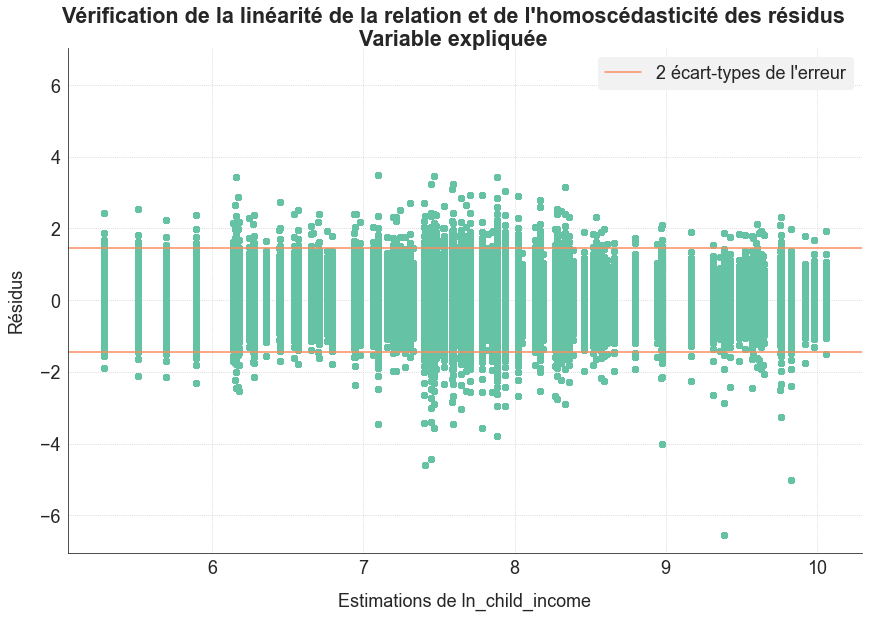

In [11]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation et de l'homoscédasticité des résidus\nVariable expliquée", is_mono=False)
mygraph.add_plot(anova.fittedvalues, anova.resid, label="", marker='o', linestyle='', with_grid='both', grid_style=":")
yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1])
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Estimations de ln_child_income")
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04c_03_linearite_homoscedasticite_endo.png")
plt.show()

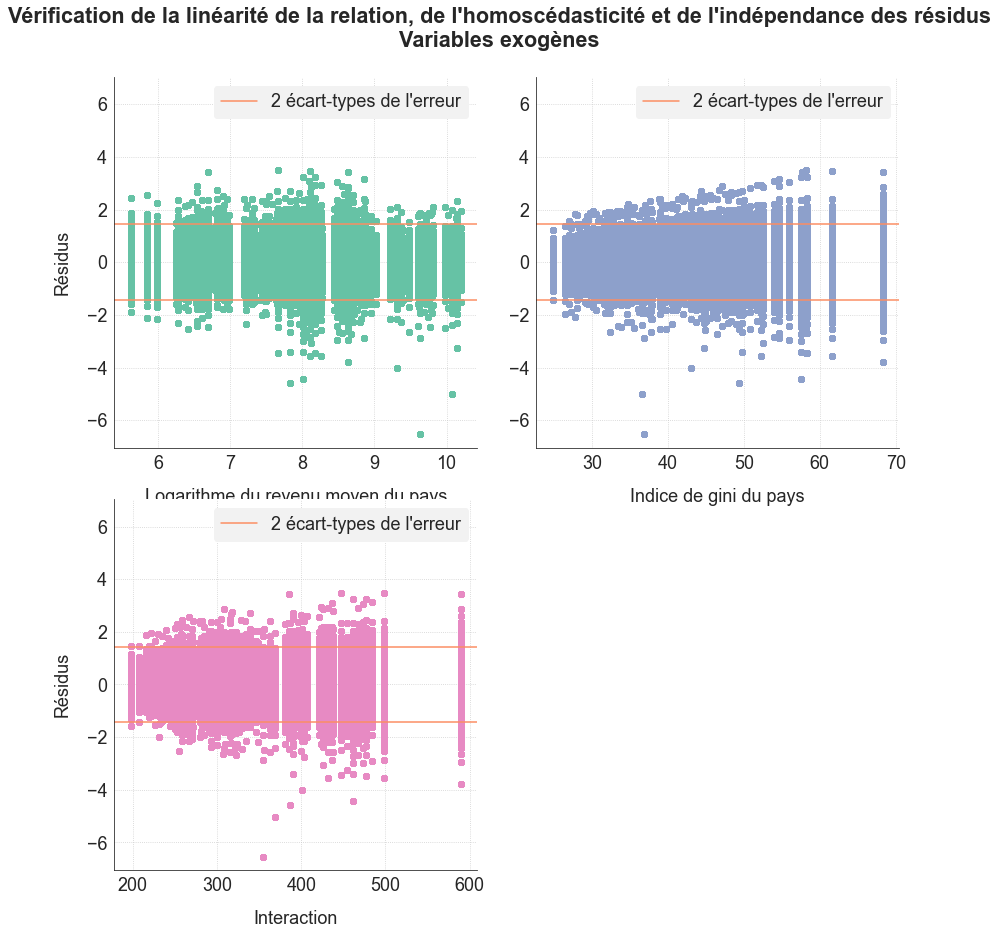

In [12]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation, de l'homoscédasticité et de l'indépendance des résidus\nVariables exogènes", nblin=2, nbcol=2, is_mono=False)
mygraph.add_plot(data.ln_revenu_moyen, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[0], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.gini_from_centiles, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[2], linestyle='', with_grid='both', grid_style=":", multi_index=2)
mygraph.add_plot(data.gini_from_centiles * data.ln_revenu_moyen, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[3], linestyle='', with_grid='both', grid_style=":", multi_index=3)
#yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=1)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=1)
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=2)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=2)
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=3)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=3)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Logarithme du revenu moyen du pays", multi_index=1)
mygraph.set_axe('x', label="Indice de gini du pays", multi_index=2)
mygraph.set_axe('x', label="Interaction", multi_index=3)
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax, multi_index=1)
mygraph.set_axe('y', tick_min=-absmax, tick_max=absmax, multi_index=2)
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax, multi_index=3)
mygraph.ax[3].set_visible(False)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04c_04_linearite_homoscedasticite_exo.png")
plt.show()

In [13]:
alpha_homo = 0.05
lm_stat, lm_pvalue, f_stat, f_pvalue = sm.stats.diagnostic.het_breuschpagan(anova.resid, anova.model.exog)
if f_pvalue >= alpha_homo:
    test_result = ["Homoscédasticité acceptée"]
else:
    test_result = ["Homoscédasticité rejetée"]
pd.DataFrame({'H0':["Variance des résidus constante"], 'Statistique':["{:.2f}".format(f_stat)], \
             'p-value':["{:.3f}".format(f_pvalue)], 'Résultat (seuil={:.1%})'.format(alpha_homo):test_result}, index=["Breusch Pagan"])

,H0,Statistique,p-value,Résultat (seuil=5.0%)
Breusch Pagan,Variance des résidus constante,121475.08,0.000,Homoscédasticité rejetée


L'homoscédasticité est rejetée par le test. L'ajout de l'interaction ne modifie pas les graphiques du modèle initial et ne répondent pas aux questions sur l'indépendance des résidus vis-à-vis de l'indice de Gini.

**Conclusion sur les hypothèses**

Les graphiques permettent d'accepter les 3 hypothèses. Ils montrent que l'ajout de l'interaction n'amèliore pas mais ne dégrade pas non plus le modèle.

**Vérification supplémentaire : absence de colinéarité entre les exogènes**

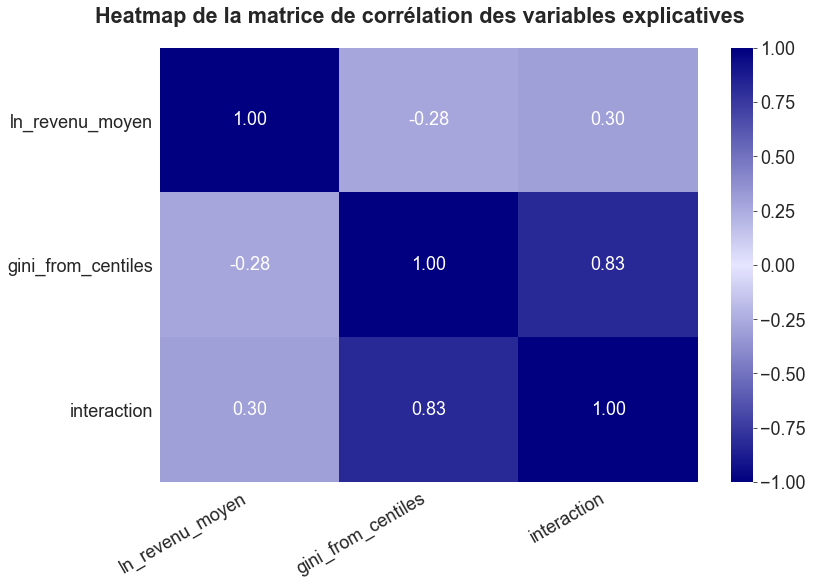

In [14]:
matrice_correl = np.corrcoef(data[["ln_revenu_moyen","gini_from_centiles","interaction"]], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=["ln_revenu_moyen","gini_from_centiles","interaction"], rotation=0)
mygraph.set_axe('x', tick_labels=["ln_revenu_moyen","gini_from_centiles","interaction"], rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04c_05_matrice_correl.png")
plt.show()

In [15]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
ln_revenu_moyen,34.418293
gini_from_centiles,99.082210
ln_revenu_moyen:gini_from_centiles,100.390044


L'ajout de l'interaction crée un problème de colinéarité simple (corrélation entre l'indice de Gini et l'interaction supérieure à 0,8) et multiple (tous les indices VIF sont très largement supérieurs à 4).

**Conclusion sur cette variante**

Sans analyser la concordance des estimations ni les valeurs atypiques, on se rend compte que l'ajout de l'interaction n'est pas une bonne idée. Cette opération introduit un grave problème de colinéarité. Cette idée est abandonnée.